In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
#Get a list of column names and types
inspector = inspect(engine)
inspector.get_table_names()
print('Measurement')
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
print('--')
print('Station')
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])   
    
#view data
print('--')
print('5 rows of Measurement Data')
preview = engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()
preview

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--
Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
--
5 rows of Measurement Data


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

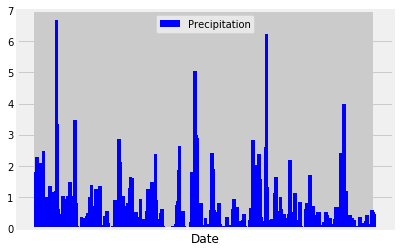

In [13]:
#last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print('--')
# print(f'(The most recent date in the data is {last_date}')

#Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# print('--')
# print(f'(One year from the most recent date is {year_ago}')

#query to retrieve the last 12 months of precipitation data
sel = [Measurement.prcp, Measurement.date]
prcp_q = session.query(*sel).\
    filter(Measurement.date >= year_ago).all()
# prcp_q

#put results into dataframe, set index, and sort by date
prcp_df = pd.DataFrame(prcp_q, columns=['Percipitation', 'Date'])
prcp_df.set_index('Date', inplace=True)
prcp_dfs = prcp_df.sort_values('Date')
prcp_dfsd = prcp_dfs.dropna(how='any')
# prcp_dfsd

#plot 
x_axis = prcp_dfsd.index
y_axis = prcp_dfsd.Percipitation
plt.bar(x_axis, y_axis, color='b', alpha=1, align='edge', width=4)
plt.tick_params(axis="x", labelbottom=False)
plt.ylim(0, 7)
plt.legend(["Precipitation"], loc="upper center")
plt.xlabel("Date")
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_dfsd.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
station = session.query(Station.station).count()
station

9

In [16]:
# List the stations and the counts in descending order.
activestations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Which station has the highest number of observations?
mostactivestation = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
mostactivestation

('USC00519281')

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowhighavg = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
lowhighavg

[(54.0, 85.0, 71.66378066378067)]

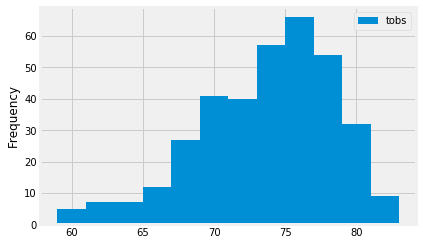

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#tobs last date for most active station
tobs = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc())
tobslastdate = tobs.first()
# print('--')
# print(f'(The most recent date in the tobs data is {tobslastdate}')

#Calculate the date 1 year ago from the last data point in tobs
tobs_year_ago = dt.date(2017, 8, 18) - dt.timedelta(days=365)
# print('--')
# print(f'(One year from the most recent tobs date is {tobs_year_ago}')

#query to retrieve the last 12 months of tobs data
sel = [Measurement.tobs, Measurement.date]
tobs_q = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= tobs_year_ago).all()
#tobs_q

#put results into dataframe, set index, and sort by date
tobs_df = pd.DataFrame(tobs_q, columns=['tobs', 'Date'])
tobs_df.set_index('Date', inplace=True)
tobs_dfs = tobs_df.sort_values('Date')
tobs_dfsd = tobs_dfs.dropna(how='any')

#plot tobs results as histogram
x_tobs = tobs_dfsd.tobs
plt.hist(x_tobs, bins=12)
plt.legend(["tobs"], loc="upper right")
plt.ylabel("Frequency")
plt.show()

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# create vacation range 3-15 days: 
# Selected 8/7/17 through 8/19/17 (13 days) to celebrate daughter's birthday so I can win the best mom award!!!

vaca = calc_temps('2017-08-07', '2017-08-19')
vaca

[(70.0, 78.45283018867924, 85.0)]

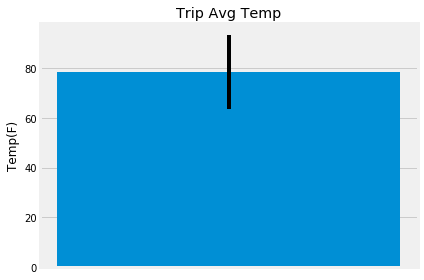

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#unpack results and save into variable
vaca_min = vaca[0][0] 
vaca_avg = vaca[0][1] 
vaca_max = vaca[0][2] 

fig, ax = plt.subplots()
minmax = (vaca_max - vaca_min)
ax.bar(0, height=vaca_avg, width=.5, yerr=minmax)
plt.xticks([])
ax.set_title('Trip Avg Temp')
plt.ylabel('Temp(F)')
fig.tight_layout()
plt.show()

In [35]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#copied above but haven't made all modifications yet
def rain(start_date, end_date):
    return session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.station==Station.station).\
        group_by(Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        order_by(func.sum(Measurement.prcp).desc()).all()
print(rain('2017-08-07', '2017-08-19'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.03), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.51), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.26), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.11), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02)]
